In [ ]:
import sys
import os
import torch
import torch.distributed as dist
import torchsummary
import torch.optim as optim
import numpy as np
import torchvision.utils
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from torch import nn, Tensor
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import v2
from PIL import Image
from CustomDataset import CustomDataset
from metrics import evaluate

transform = v2.Compose([
    # v2.Resize((224,224)),
    # v2.RandomRotation(degrees=(0,180)),
    v2.Compose([v2.ToImage(),v2.ToDtype(torch.float32,scale=True)]),
    # v2.Normalize([0.485], [0.229]),
])
train_dataset = CustomDataset(root_dir="../training",transform=transform)
val_dataset = CustomDataset(root_dir="../validation",transform=transform)

train_loader = DataLoader(train_dataset,batch_size=32,shuffle=False)
val_loader = DataLoader(val_dataset,batch_size=32,shuffle=False)

In [4]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.encoder = nn.ModuleList([
            DoubleConv(in_channels, 64),
            DoubleConv(64, 128),
            DoubleConv(128, 256),
            DoubleConv(256, 512),
            DoubleConv(512, 1024)
        ])
        
        self.decoder = nn.ModuleList([
            DoubleConv(1024 + 512, 512),  # Adjusted for concatenation
            DoubleConv(512 + 256, 256),   # Adjusted for concatenation
            DoubleConv(256 + 128, 128),   # Adjusted for concatenation
            DoubleConv(128 + 64, 64),     # Adjusted for concatenation
        ])
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        encoder_outputs = []
        for encoder in self.encoder:
            x = encoder(x)
            encoder_outputs.append(x)
            x = nn.MaxPool2d(kernel_size=2)(x)
        x = self.upsample(x)
        # Decoder
        for i, (decoder, encoder_output) in enumerate(zip(self.decoder, reversed(encoder_outputs[:-1]))):
            # print(x.shape)
            x = self.upsample(x)
            # print(f"Shape of x after upsampling in decoder {i+1}: {x.shape}")
            x = torch.cat([x, encoder_output], dim=1)
            x = decoder(x)
        
        # Final Convolution
        x = self.final_conv(x)
        # x = torch.sigmoid(x)  # Assuming binary segmentation
        return x

    # def upsample(self, x):
    #     return nn.ConvTranspose2d(x.shape[1], x.shape[1], kernel_size=2, stride=2).forward(x).to('cuda')


## Unet Architecture

<p>Ronneberger, O., Fischer, P., & Brox, T. (2015). U-net: Convolutional networks for biomedical image segmentation. In Medical image computing and computer-assisted intervention–MICCAI 2015: 18th international conference, Munich, Germany, October 5-9, proceedings, part III 18 (pp. 234-241). Springer International Publishing, 2015.</p>

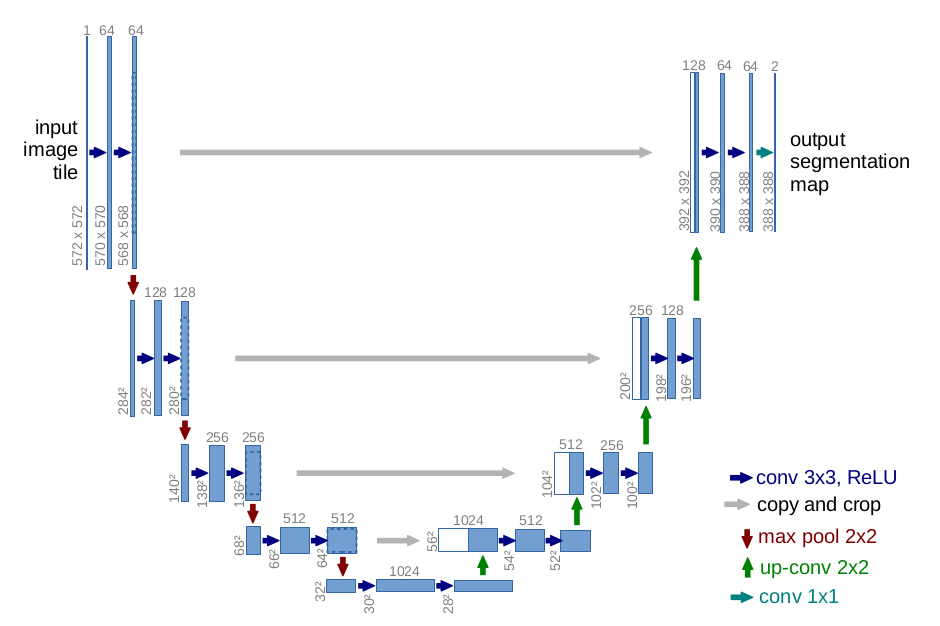

In [ ]:
model = UNet(in_channels=1, out_channels=1).to('cuda')
torchsummary.summary(model, input_size=(1,224,224))

In [5]:
import torch.optim as optim
import matplotlib.pyplot as plt
import wandb

train_iou_history = []
val_iou_history = []

device = torch.device('cuda')

criterion = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)
logs = wandb.init(project="Unet model")

best_acc = 0

num_epochs = 100 
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for data in train_loader:
        for images, masks, eye_masks in data:
            images = images.cuda()
            masks = masks.cuda()
            
            optimizer.zero_grad()
            
            outputs = model(images)
            outputs = torch.sigmoid(outputs)
            loss = criterion(outputs, masks)

            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    acc, se, sp, F1, pr, AUC_ROC, dice, iou = evaluate(model, val_loader, num_classes=2)
    logs.log({
        "acc": acc,
        "sensitivity": se,
        "specificity": sp,
        "F1-score": F1,
        "AUC_ROC": AUC_ROC,
        "Dice": dice,
        "epoch": epoch,
        "IOU": iou
    })
    if best_acc < acc:
        best_acc = acc
        print(f"Best accuracy attained: {best_acc*100:.4f}%")
        torch.save(model.state_dict(),"unet_model.pth")
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {acc*100:.4f}%, IOU: {iou}')

wandb: Currently logged in as: battulasaikiran2002. Use `wandb login --relogin` to force relogin


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.07s/it]


Best accuracy attained: 90.4111%
Epoch [1/100], Loss: 51.6498, Accuracy: 90.4111%, IOU: 0.4858096198666663


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.01s/it]


Best accuracy attained: 93.1440%
Epoch [2/100], Loss: 36.9695, Accuracy: 93.1440%, IOU: 0.44009455499194916


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  6.00s/it]


Best accuracy attained: 93.8739%
Epoch [3/100], Loss: 32.5368, Accuracy: 93.8739%, IOU: 0.4714545215879168


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.29s/it]


Best accuracy attained: 93.9483%
Epoch [4/100], Loss: 30.4811, Accuracy: 93.9483%, IOU: 0.5591428765228816


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.06s/it]


Best accuracy attained: 94.3704%
Epoch [5/100], Loss: 27.3937, Accuracy: 94.3704%, IOU: 0.5252302968785876


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.99s/it]


Epoch [6/100], Loss: 25.9907, Accuracy: 92.9981%, IOU: 0.42049943116449173


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.07s/it]


Epoch [7/100], Loss: 25.1190, Accuracy: 93.7975%, IOU: 0.48550162059920177


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.05s/it]


Best accuracy attained: 94.4790%
Epoch [8/100], Loss: 23.8302, Accuracy: 94.4790%, IOU: 0.5620848513784863


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.07s/it]


Best accuracy attained: 94.7334%
Epoch [9/100], Loss: 23.4382, Accuracy: 94.7334%, IOU: 0.5500933079492478


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.99s/it]


Epoch [10/100], Loss: 22.3402, Accuracy: 94.6189%, IOU: 0.5663014241627284


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.23s/it]


Epoch [11/100], Loss: 22.1279, Accuracy: 94.5931%, IOU: 0.5929111527545111


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.98s/it]


Epoch [12/100], Loss: 21.6006, Accuracy: 94.5041%, IOU: 0.5508337533899716


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.42s/it]


Epoch [13/100], Loss: 21.1257, Accuracy: 94.2781%, IOU: 0.5352489275591714


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.05s/it]


Epoch [14/100], Loss: 20.8553, Accuracy: 94.6298%, IOU: 0.5572763424544107


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.09s/it]


Epoch [15/100], Loss: 20.6796, Accuracy: 94.2039%, IOU: 0.5450105865086828


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.97s/it]


Best accuracy attained: 95.2779%
Epoch [16/100], Loss: 20.0374, Accuracy: 95.2779%, IOU: 0.6066307953425816


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.24s/it]


Epoch [17/100], Loss: 19.0789, Accuracy: 94.7532%, IOU: 0.5734066274904069


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.97s/it]


Epoch [18/100], Loss: 19.0194, Accuracy: 94.2880%, IOU: 0.5326956483934607


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.05s/it]


Epoch [19/100], Loss: 18.6350, Accuracy: 94.3061%, IOU: 0.5621539164157141


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.22s/it]


Epoch [20/100], Loss: 18.0424, Accuracy: 95.2408%, IOU: 0.6000485230059851


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.22s/it]


Epoch [21/100], Loss: 17.6532, Accuracy: 94.7653%, IOU: 0.5726582582507814


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.97s/it]


Epoch [22/100], Loss: 17.3433, Accuracy: 95.2369%, IOU: 0.6126405883403051


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.24s/it]


Epoch [23/100], Loss: 17.1187, Accuracy: 95.0966%, IOU: 0.5804349602687926


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.25s/it]


Epoch [24/100], Loss: 16.2944, Accuracy: 94.4638%, IOU: 0.5283471927046776


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.06s/it]


Epoch [25/100], Loss: 16.0692, Accuracy: 95.2200%, IOU: 0.5978518241572948


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.21s/it]


Epoch [26/100], Loss: 15.4602, Accuracy: 95.1522%, IOU: 0.6225048854237512


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.02s/it]


Best accuracy attained: 95.5808%
Epoch [27/100], Loss: 14.8966, Accuracy: 95.5808%, IOU: 0.6164043415160406


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.07s/it]


Epoch [28/100], Loss: 15.1253, Accuracy: 95.4209%, IOU: 0.6033721181608381


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.02s/it]


Best accuracy attained: 95.6002%
Epoch [29/100], Loss: 13.8253, Accuracy: 95.6002%, IOU: 0.635479580220722


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.08s/it]


Best accuracy attained: 95.7925%
Epoch [30/100], Loss: 13.8288, Accuracy: 95.7925%, IOU: 0.6694997963451204


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.05s/it]


Epoch [31/100], Loss: 13.2198, Accuracy: 94.7203%, IOU: 0.5408643763689768


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.02s/it]


Epoch [32/100], Loss: 12.7069, Accuracy: 95.2357%, IOU: 0.5814927609193893


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.12s/it]


Epoch [33/100], Loss: 12.7891, Accuracy: 94.8390%, IOU: 0.5633358637491862


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.02s/it]


Epoch [34/100], Loss: 11.9962, Accuracy: 95.4539%, IOU: 0.6167715536696571


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.25s/it]


Epoch [35/100], Loss: 11.8812, Accuracy: 94.9411%, IOU: 0.5797662610454218


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.98s/it]


Epoch [36/100], Loss: 11.3567, Accuracy: 95.4694%, IOU: 0.6277887724694752


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.97s/it]


Epoch [37/100], Loss: 10.5862, Accuracy: 95.5739%, IOU: 0.6106280947015399


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.27s/it]


Epoch [38/100], Loss: 9.7186, Accuracy: 95.7488%, IOU: 0.6331538091103236


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.21s/it]


Epoch [39/100], Loss: 9.4235, Accuracy: 94.7494%, IOU: 0.5666855611971446


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.99s/it]


Epoch [40/100], Loss: 9.7942, Accuracy: 95.1996%, IOU: 0.5973445347377232


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.06s/it]


Epoch [41/100], Loss: 9.6486, Accuracy: 95.3255%, IOU: 0.6185293901534308


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.41s/it]


Best accuracy attained: 96.1071%
Epoch [42/100], Loss: 9.6560, Accuracy: 96.1071%, IOU: 0.6606296963634946


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.98s/it]


Epoch [43/100], Loss: 8.4946, Accuracy: 95.9851%, IOU: 0.6522626025336129


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.95s/it]


Best accuracy attained: 96.1352%
Epoch [44/100], Loss: 8.9182, Accuracy: 96.1352%, IOU: 0.6717984717516672


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.05s/it]


Best accuracy attained: 96.4335%
Epoch [45/100], Loss: 7.7395, Accuracy: 96.4335%, IOU: 0.6947263484909421


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.95s/it]


Epoch [46/100], Loss: 7.7724, Accuracy: 96.1038%, IOU: 0.6711002544278191


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.23s/it]


Epoch [47/100], Loss: 8.0743, Accuracy: 95.5888%, IOU: 0.6208857794602712


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.96s/it]


Epoch [48/100], Loss: 7.1972, Accuracy: 95.3836%, IOU: 0.6167613419748488


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.21s/it]


Epoch [49/100], Loss: 6.4703, Accuracy: 96.1946%, IOU: 0.6794279593796957


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.96s/it]


Epoch [50/100], Loss: 7.3761, Accuracy: 96.0349%, IOU: 0.6711042963323139


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.97s/it]


Best accuracy attained: 97.2980%
Epoch [51/100], Loss: 6.6195, Accuracy: 97.2980%, IOU: 0.7606634588468643


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.20s/it]


Epoch [52/100], Loss: 6.0398, Accuracy: 96.5917%, IOU: 0.711377687681289


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.01s/it]


Epoch [53/100], Loss: 6.1795, Accuracy: 96.9564%, IOU: 0.7324685460045224


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.22s/it]


Epoch [54/100], Loss: 5.2663, Accuracy: 96.2813%, IOU: 0.6832997972056979


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.23s/it]


Epoch [55/100], Loss: 5.3815, Accuracy: 95.6953%, IOU: 0.651933098974682


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.27s/it]


Best accuracy attained: 97.4944%
Epoch [56/100], Loss: 5.4947, Accuracy: 97.4944%, IOU: 0.7820261688459487


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.04s/it]


Epoch [57/100], Loss: 5.3900, Accuracy: 97.3385%, IOU: 0.7689753680002122


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.03s/it]


Best accuracy attained: 97.7096%
Epoch [58/100], Loss: 4.5000, Accuracy: 97.7096%, IOU: 0.7846968775703793


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.39s/it]


Epoch [59/100], Loss: 4.7135, Accuracy: 96.8168%, IOU: 0.7158091681344169


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.11s/it]


Epoch [60/100], Loss: 4.3792, Accuracy: 97.0885%, IOU: 0.7393926839033763


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.09s/it]


Epoch [61/100], Loss: 4.5740, Accuracy: 96.6124%, IOU: 0.7041799086899985


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.04s/it]


Epoch [62/100], Loss: 4.9271, Accuracy: 96.4902%, IOU: 0.6924875685146876


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.96s/it]


Epoch [63/100], Loss: 4.2274, Accuracy: 96.8220%, IOU: 0.7324786058494023


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.36s/it]


Epoch [64/100], Loss: 4.0128, Accuracy: 97.2919%, IOU: 0.7746527282964616


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.39s/it]


Epoch [65/100], Loss: 3.7491, Accuracy: 97.3548%, IOU: 0.7626652655147371


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.01s/it]


Epoch [66/100], Loss: 3.7357, Accuracy: 96.8429%, IOU: 0.7379628530570439


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.94s/it]


Epoch [67/100], Loss: 3.7670, Accuracy: 97.2413%, IOU: 0.7535975232010796


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.98s/it]


Epoch [68/100], Loss: 3.7591, Accuracy: 96.9097%, IOU: 0.7306898644992283


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.25s/it]


Epoch [69/100], Loss: 3.2928, Accuracy: 96.2157%, IOU: 0.681316695752598


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.24s/it]


Epoch [70/100], Loss: 3.1869, Accuracy: 96.6727%, IOU: 0.7227466495264144


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.07s/it]


Best accuracy attained: 98.1493%
Epoch [71/100], Loss: 3.2730, Accuracy: 98.1493%, IOU: 0.8298289199670156


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.14s/it]


Epoch [72/100], Loss: 3.0667, Accuracy: 97.3326%, IOU: 0.7575636066141582


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.99s/it]


Epoch [73/100], Loss: 3.2032, Accuracy: 97.1845%, IOU: 0.7560756958666301


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.97s/it]


Best accuracy attained: 98.1766%
Epoch [74/100], Loss: 2.7881, Accuracy: 98.1766%, IOU: 0.8266256985210237


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.23s/it]


Epoch [75/100], Loss: 2.6708, Accuracy: 97.4876%, IOU: 0.7837949684688024


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.96s/it]


Epoch [76/100], Loss: 2.4546, Accuracy: 97.4487%, IOU: 0.772239295073918


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.25s/it]


Epoch [77/100], Loss: 2.5125, Accuracy: 98.0336%, IOU: 0.8193459011259533


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.01s/it]


Epoch [78/100], Loss: 2.4981, Accuracy: 97.5088%, IOU: 0.7742296911421276


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.05s/it]


Best accuracy attained: 98.2898%
Epoch [79/100], Loss: 2.3174, Accuracy: 98.2898%, IOU: 0.8394485232375917


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.09s/it]


Epoch [80/100], Loss: 2.5326, Accuracy: 97.5760%, IOU: 0.7817773682730539


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.04s/it]


Epoch [81/100], Loss: 2.2691, Accuracy: 97.1993%, IOU: 0.752090512287049


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.05s/it]


Epoch [82/100], Loss: 2.1725, Accuracy: 97.8691%, IOU: 0.809790680805842


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.31s/it]


Epoch [83/100], Loss: 2.0800, Accuracy: 97.6323%, IOU: 0.7916524302391779


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.99s/it]


Epoch [84/100], Loss: 1.9258, Accuracy: 98.1589%, IOU: 0.8301397158986046


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.28s/it]


Epoch [85/100], Loss: 1.7488, Accuracy: 98.0515%, IOU: 0.8193391902106149


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.22s/it]


Epoch [86/100], Loss: 1.9756, Accuracy: 97.4809%, IOU: 0.7758887543564751


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.98s/it]


Epoch [87/100], Loss: 1.8971, Accuracy: 97.6056%, IOU: 0.7811622611113958


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.31s/it]


Epoch [88/100], Loss: 1.6995, Accuracy: 96.8913%, IOU: 0.7275875432150705


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.29s/it]


Epoch [89/100], Loss: 1.5005, Accuracy: 97.9443%, IOU: 0.813608136347362


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.37s/it]


Epoch [90/100], Loss: 1.3741, Accuracy: 97.9125%, IOU: 0.8049837135133289


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.97s/it]


Epoch [91/100], Loss: 1.6574, Accuracy: 98.1189%, IOU: 0.827601291735967


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.08s/it]


Epoch [92/100], Loss: 1.4425, Accuracy: 97.7669%, IOU: 0.7987133786791847


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.15s/it]


Epoch [93/100], Loss: 1.4516, Accuracy: 97.8673%, IOU: 0.8020815772669656


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.25s/it]


Epoch [94/100], Loss: 1.2184, Accuracy: 97.8354%, IOU: 0.802188075156439


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.98s/it]


Epoch [95/100], Loss: 0.9466, Accuracy: 97.6446%, IOU: 0.7889321772825151


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.08s/it]


Epoch [96/100], Loss: 1.3593, Accuracy: 98.2136%, IOU: 0.8368731552646274


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.06s/it]


Epoch [97/100], Loss: 1.3547, Accuracy: 98.1909%, IOU: 0.8332467050779433


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.05s/it]


Epoch [98/100], Loss: 0.9210, Accuracy: 98.2443%, IOU: 0.8425060865424928


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.06s/it]


Epoch [99/100], Loss: 0.7999, Accuracy: 97.9393%, IOU: 0.8102752018542517


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.22s/it]


Best accuracy attained: 98.9195%
Epoch [100/100], Loss: 0.8721, Accuracy: 98.9195%, IOU: 0.8944807733808245


In [ ]:
# torch.save(model.state_dict(),"unet_model.pth")

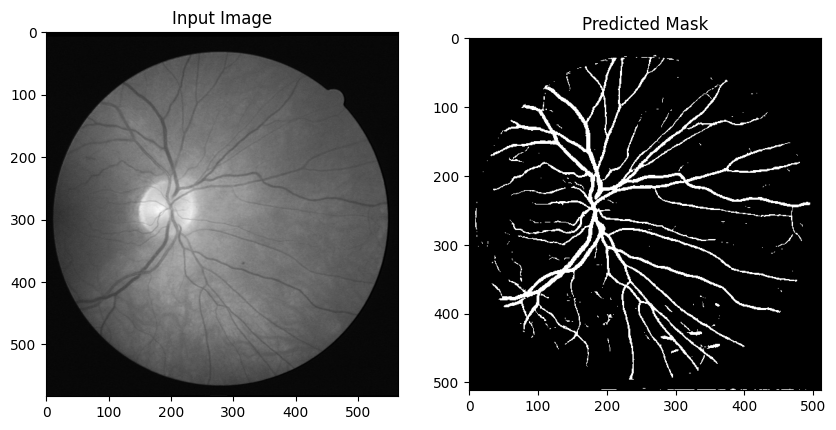

In [6]:
import torch
from torchvision import transforms
from PIL import Image

model = UNet(in_channels=1, out_channels=1).to('cuda')
model.load_state_dict(torch.load("unet_model.pth"))
model.eval()


transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])


input_image = Image.open('15_test.tif').convert('L')  
input_tensor = transform(input_image).unsqueeze(0) 


with torch.no_grad():
    output = model(input_tensor.cuda())

output = torch.sigmoid(output)
predicted_mask = (output > 0.5).float()


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(input_image,cmap='gray')
plt.title('Input Image')

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask.squeeze().cpu().numpy(), cmap='gray')
plt.title('Predicted Mask')

plt.show()